In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

import string
punctuations = string.punctuation
from nltk.corpus import stopwords
stopword_list = stopwords.words("english")
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
def clean(text):
    cleaned_text = text.lower()
    cleaned_text=re.sub("[^a-zA-Z]"," ",cleaned_text)
    cleaned_text=re.sub(r'\b\w{1,3}\b', '',cleaned_text)

    cleaned_text = "".join(c for c in cleaned_text if c not in punctuations)
    words = cleaned_text.split()
    words = [w for w in words if w not in stopword_list]
     
    words = [lem.lemmatize(word,"v") for word in words]
    words = [lem.lemmatize(word,"n") for word in words]
    words = [lem.lemmatize(word,"r") for word in words]
    cleaned_text = " ".join(words)
    
    return cleaned_text

In [3]:
df=pd.read_csv('tweetdata.csv')
df.drop(columns =['id', 'Unnamed: 0', 'score'],axis=1, inplace=True)
df.head()

,tweet,label
0,At the point today where if someone says somet...,anger
1,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger
2,This game has pissed me off more than any othe...,anger
3,@spamvicious I've just found out it's Candice ...,anger
4,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger


In [4]:
df['clean_text']=df['tweet'].apply(clean)
df.drop(['tweet'],axis=1,inplace=True)
df.head()

,label,clean_text
0,anger,point today someone say something remotely kin...
1,anger,corningfootball game minus relentless
2,anger,game piss game year blood boil time turn stlcards
3,anger,spamvicious find candice candace pout like
4,anger,moocowward mrsajhargreaves melly garybarlow co...


In [5]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(df['label'])
y

array([0, 0, 0, ..., 3, 3, 3])

In [8]:
texts=[]
for i in df['clean_text']:
    texts.append(clean(i))

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(texts,y,test_size=0.3,random_state=0,shuffle=True)

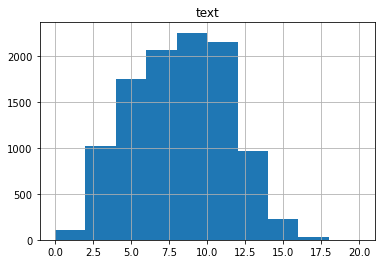

In [11]:
#padiing the sequences
import matplotlib.pyplot as plt

text_word_count=[]

#populating the list with the lenght of the sequences
for i in texts:
    text_word_count.append(len(i.split()))

length_df=pd.DataFrame({'text':text_word_count})
length_df.hist(bins=10, range=(0,20))
plt.show()

In [12]:
max_len=11

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer=Tokenizer()
tokenizer.fit_on_texts(list(x_train))
x_train

['tweet faver reaper become reaper find story wiki thru comic animate short',
 'behavior others destroy inner peace dalai lama owntv heal depression anxiety intuition meditation book',
 'barbarasgarden thank much many challenge much rejoice',
 'elate take tomorrow doneeeee',
 'gardiner love thank much gloria sweet thoughtful make joyful love',
 'absolutely fume scratch',
 'could happier happy',
 'home damn much everything start irritate need house',
 'many protest peace lately people burn city hometown practice preach',
 'love something come back never sadness accept',
 'lesyoung rabid ride child flesh fellow limb adult',
 'lucidhurricane wait mean book shock',
 'ldhranousby robharris incline think documentary harm good despair people critical faculty',
 'miss fact burkeramsey swing sister jonbenet face golf club previously',
 'playful shit',
 'much vixx keep smile',
 'shabazz name phone easy breezy beautiful apologize',
 'good head good heart always formidable combination nelson mande

In [14]:
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)

In [15]:
#padding with zero
x_train = pad_sequences(x_train,maxlen=max_len, padding='post')
x_val   = pad_sequences(x_val,maxlen=max_len, padding='post')

vocabulary=len(tokenizer.word_index) +1
print('Vocabulary size:',vocabulary)

Vocabulary size: 10690


In [16]:
from keras.utils.np_utils import to_categorical
y_train=to_categorical(y_train,num_classes=4)
y_val=to_categorical(y_val,num_classes=4)

# Model Building

In [17]:
#lSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
K.clear_session()

#LSTM Model
model=Sequential()
model.add(Embedding(vocabulary,100,input_length=max_len,trainable=True,mask_zero=True))
model.add(LSTM(300,dropout=0.1,recurrent_dropout=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(4,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           1069000   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               481200    
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,569,724
Trainable params: 1,569,724
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])


In [19]:
callbacks = [EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=2),
             ModelCheckpoint(filepath='best_model.h5', 
             monitor='val_loss',mode='min',save_best_only=True)]

In [20]:
history=model.fit(np.array(x_train),np.array(y_train),batch_size=32,epochs=30,callbacks=callbacks,validation_data=(np.array(x_val),np.array(y_val)))

Epoch 1/30
232/232 [==============================] - 60s 259ms/step - loss: 0.7449 - acc: 0.7059 - val_loss: 0.3152 - val_acc: 0.8933
Epoch 2/30
232/232 [==============================] - 58s 248ms/step - loss: 0.1692 - acc: 0.9444 - val_loss: 0.2537 - val_acc: 0.9100
Epoch 3/30
232/232 [==============================] - 56s 242ms/step - loss: 0.0972 - acc: 0.9653 - val_loss: 0.2695 - val_acc: 0.9091
Epoch 4/30
232/232 [==============================] - 56s 241ms/step - loss: 0.0761 - acc: 0.9702 - val_loss: 0.2628 - val_acc: 0.9166
Epoch 00004: early stopping


In [21]:
from keras.models import load_model
model=load_model('best_model.h5')
from sklearn.metrics import classification_report
y_pred=model.predict_classes(np.array(x_val))
y_true=np.argmax(y_val,axis=1)
print(classification_report(y_true,y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       772
           1       0.92      0.90      0.91      1004
           2       0.96      0.93      0.94       726
           3       0.86      0.88      0.87       676

    accuracy                           0.91      3178
   macro avg       0.91      0.91      0.91      3178
weighted avg       0.91      0.91      0.91      3178



# Using GRU

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
K.clear_session()

model2=Sequential()
model2.add(Embedding(vocabulary,100,input_length=max_len,trainable=True,mask_zero=True))
model2.add(GRU(300,dropout=0.1,recurrent_dropout=0.2))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(4,activation='softmax'))
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           1069000   
_________________________________________________________________
gru (GRU)                    (None, 300)               361800    
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,450,324
Trainable params: 1,450,324
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [26]:
callbacks_gru = [EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4),
             ModelCheckpoint(filepath='best_model_gru.h5', 
             monitor='val_loss',mode='min',save_best_only=True)]


In [27]:
history2=model.fit(np.array(x_train),np.array(y_train),batch_size=32,epochs=30,callbacks=callbacks_gru,validation_data=(np.array(x_val),np.array(y_val)))

Epoch 1/30
232/232 [==============================] - 54s 233ms/step - loss: 0.0529 - acc: 0.9730 - val_loss: 0.3111 - val_acc: 0.9135
Epoch 2/30
232/232 [==============================] - 56s 239ms/step - loss: 0.0545 - acc: 0.9721 - val_loss: 0.3471 - val_acc: 0.9056
Epoch 3/30
232/232 [==============================] - 64s 277ms/step - loss: 0.0492 - acc: 0.9714 - val_loss: 0.3203 - val_acc: 0.9062
Epoch 4/30
232/232 [==============================] - 58s 252ms/step - loss: 0.0434 - acc: 0.9740 - val_loss: 0.4046 - val_acc: 0.9087
Epoch 5/30
232/232 [==============================] - 59s 254ms/step - loss: 0.0497 - acc: 0.9740 - val_loss: 0.3816 - val_acc: 0.8990
Epoch 00005: early stopping


In [28]:
from keras.models import load_model
model=load_model('best_model_gru.h5')
from sklearn.metrics import classification_report
y_pred=model.predict_classes(np.array(x_val))
y_true=np.argmax(y_val,axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       772
           1       0.90      0.94      0.92      1004
           2       0.97      0.94      0.95       726
           3       0.88      0.85      0.87       676

    accuracy                           0.91      3178
   macro avg       0.92      0.91      0.91      3178
weighted avg       0.91      0.91      0.91      3178

